In [1]:
%load_ext autoreload
%autoreload 2

import glob
import logging
import numpy as np
from importlib import reload  # Not needed in Python 2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset


from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs

from model import res8,UNet,UNet_Res

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
reload(logging)
logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',r=10,base=80):
    im[:r,:r] = base
    im[r,r] = 0
    im[im>base] = base
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()
    
# logging.info('\n\n\n\n\n')
# logging.info('with 3 conv grid to concat\n')
# logging.info('2res block, use simple feature: EM inventory simple,2d ALL,3d ALL\n')

class Tensor_Parameter(nn.Module):
    def __init__(self,):
        super(Tensor_Parameter,self).__init__()
        self.Input = nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        self.Input.data = x
        return self.Input


class Focal_loss_regression(nn.Module):
    def __init__(self,max_update=10,_lambda=2,):
        super(Focal_loss_regression,self).__init__()
        self._lambda = _lambda
        max_update = np.power(1/max_update,1/_lambda)
        max_update = 1/max_update
        max_update = 1/(max_update-1)
        self.max_update = max_update
        
    def forward(self,pred,target):
        diff_abs = torch.abs(pred-target)
        diff_max = (1+self.max_update)*torch.max(diff_abs)
#         diff_max.detach()
        rate = torch.pow((1-1/diff_max*diff_abs)**self._lambda,-1)
        diff_abs = rate*diff_abs
        
#         return diff_abs
        return torch.mean(diff_abs)

In [2]:

# cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_*',
#       'label':'/AS_data/Conc_npy/O3_2015_*',
#       'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
#       'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_*',
#       'METCRO3D':'',
#       'METCRO3D_5height':'',
#       'obs_label':'/AS_data/obs_npy/obs2015_*'}
cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_01*',
        'label':'/AS_data/Conc_npy/O3_2015_01*',
        'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
        'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_01*',
        'METCRO3D':'',
        'METCRO3D_5height':'',
        'obs_label':'/AS_data/obs_npy/obs2015_01_*'}

### remove CH4,AACD,ACET
EM_idx = np.array([0,2,3,4,8,9,10,32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50])

# EM_idx = np.array([0,2,3,4,8,9,10,32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,49, 50])
# EM_idx = np.array([6,7])

print('train data is loading ')
Data = AS_Data_obs(cfg,left = 0,right = 1,window = 6,EM_idx = EM_idx)
trainloader = DataLoader(Data,batch_size=1,shuffle=True)
print(len(Data))
print(Data.EM_idx)
# print('test data is loading ')
# test_Data = AS_Data_obs(cfg,left = 0.75,right = 0.98,window = 6)
# testloader = DataLoader(test_Data,batch_size=1,shuffle=False)
# print(len(test_Data))

train data is loading 
/AS_data/Conc_npy/O3_2015_01_744_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_01_744_34_182_232.npy   is loading
/AS_data/obs_npy/obs2015_01_744_6_182_232.npy   is loading
738
[ 0  2  3  4  8  9 10 32 33 34 35 36 37 38 39 42 43 44 45 46 47 48 50]


In [3]:
# test_model = res8(51+34,27,inplanes=64,layers = [2],T=24) #+5*16
# name = 'res_2layer_correctdata'
# test_model.load_state_dict(torch.load('model_save/res_2layer_9_epoch.t'))
test_model = UNet(51+34,27,T=6,bilinear=False) #+80
t2p = Tensor_Parameter()

name = 'unet2'

test_model.to(device)
t2p.to(device)
criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(test_model.parameters(),lr=1e-3)
optimizer = torch.optim.Adam(t2p.parameters(),lr=1e-2)
test_model.load_state_dict(torch.load('model_save/o3_with_foreign_unet2_5month_10_epoch.t'))
# test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

<All keys matched successfully>

In [4]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
            yt_1 = torch.unsqueeze(yt_1,1)
            input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.float().to(device)
            input = t2p(input)
            y_pred = model(input,grid,yt_1)
            y_pred = torch.squeeze(y_pred) #,dim = 2)
            y_pred = y_pred.view(label.shape)
            
            Data.update_labels(indexes,y_pred)
            if torch.sum(obs!=-999)==0:
                continue

            
            loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
            ls.append(loss.cpu().data)
        
    return np.mean(np.array(ls))

In [ ]:
for epoch in range(25):
    logging.info('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.eval()
    test_model.rnn.train()
    for idx,i in enumerate(trainloader):
        
        indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
        yt_1 = torch.unsqueeze(yt_1,1)
        input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.to(device)
        input = t2p(input)
        y_pred = test_model(input,grid,yt_1)

        y_pred = torch.squeeze(y_pred) #,dim = 2)
        if torch.sum(obs!=-999)==0:
            continue
        optimizer.zero_grad()
        
        y_pred = y_pred.view(label.shape)
        loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        
        #udpate input parameter
        Data.update(indexes,t2p.Input.data)

#         Data.update_labels(indexes,y_pred)
#         if len(ls)%400==0:
#             logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
    logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
    
#     if epoch%5 == 0:
#         torch.save(test_model.cpu().state_dict(),'model_save/finetune_input_{}_{}_epoch.t'.format(name,epoch))
#         test_model.to(device)
    if epoch%10 == 0:
        for idx,month in enumerate(['01','02','04','07','10']):
            np.save('/AS_data/finetune_input_VOC_rm_CH4_npy/month_{}_finetune_input.npy'.format(month),Data.EM[idx])

epoch 0 cur loss 29.41399574279785
epoch 1 cur loss 24.86199188232422


In [7]:
for idx,month in enumerate(['01','02','04','07','10']):
    print(idx)
    np.save('/AS_data/finetune_input_VOC_rm_CH4_npy/month_{}_finetune_input.npy'.format(month),Data.EM[idx])

0
1
2
3
4


In [5]:
fine_inputs = []
for filename in sorted(glob.glob('/AS_data/finetune_input_VOC_rm_CH4_npy/month_01*')):
    print(filename+'   is loading')
    EM = np.load(filename)
    tick,_,W,H = EM.shape
    print(tick)
    fine_inputs.append(EM[:].copy())

/AS_data/finetune_input_VOC_rm_CH4_npy/month_01_finetune_input.npy   is loading
744


In [6]:
his_idx = np.array([1])
his_value = Data.EM[0][:,his_idx].copy()

Data.EM[0][:,his_idx] = his_value

# test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
# logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
# print('-------------cur test loss L1:  {}'.format(test_score_L1))

In [7]:
import numpy as np
# idx_search = list(range(51))
idx_search = [0,2,3,4,8,9,10,32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50]
def combination(nums):
    if len(nums) == 1:
        return [[nums[0]],[]]
    f1_end = combination(nums[1:])
    return [[nums[0]]+i for i in f1_end]+f1_end


combine_idx_search = [idx_search] + [idx_search[:i]+idx_search[i+1:] for i in range(len(idx_search))]
# combine_idx_search = [np.array(i) for i in combination(idx_search)]


for idx in combine_idx_search:
    Data.EM[0][:,his_idx] = his_value
    his_idx = idx
    his_value = Data.EM[0][:,his_idx].copy()
    
    Data.EM[0][:,idx] = fine_inputs[0][:,idx]
    test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
    logging.info('-------------EM idx is {},cur test loss L1:  {}'.format(idx,test_score_L1))
    print('-------------EM idx is {},cur test loss L1:  {}'.format(idx,test_score_L1))

-------------EM idx is [0, 2, 3, 4, 8, 9, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  8.618678092956543
-------------EM idx is [2, 3, 4, 8, 9, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  8.691277503967285
-------------EM idx is [0, 3, 4, 8, 9, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  8.656288146972656
-------------EM idx is [0, 2, 4, 8, 9, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  8.667903900146484
-------------EM idx is [0, 2, 3, 8, 9, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  15.679267883300781
-------------EM idx is [0, 2, 3, 4, 9, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  8.627066612243652
-------------EM idx is [0, 2, 3, 4, 8, 10, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50],cur test loss L1:  8.6350

0.14539652


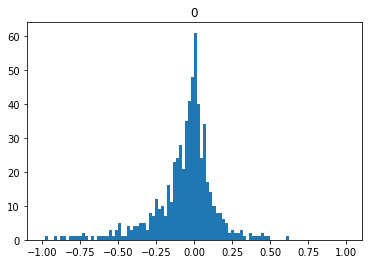

0.29184833


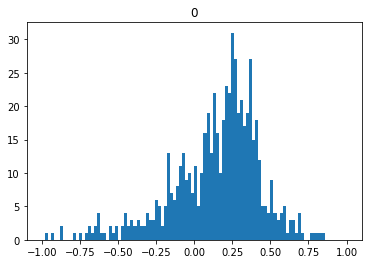

0.3820005


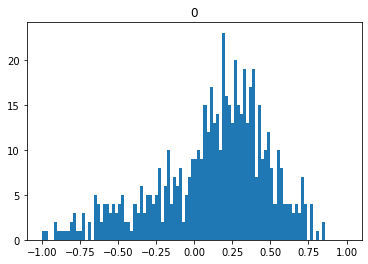

0.13251483


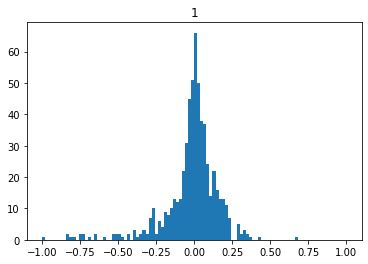

0.3099303


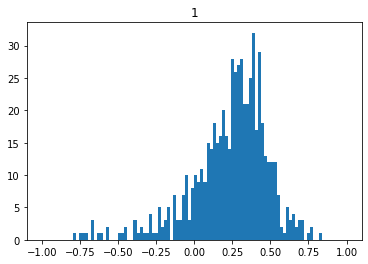

0.38553756


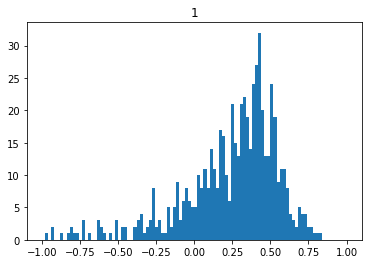

0.14255239


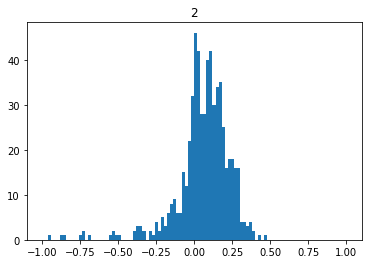

0.32258847


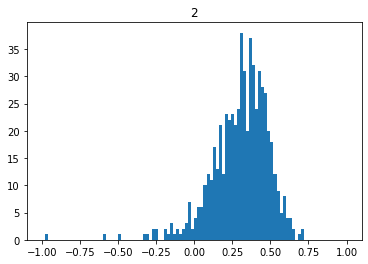

0.42805904


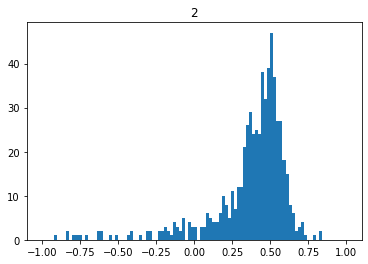

0.15378994


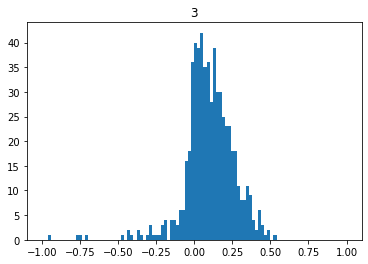

0.37214836


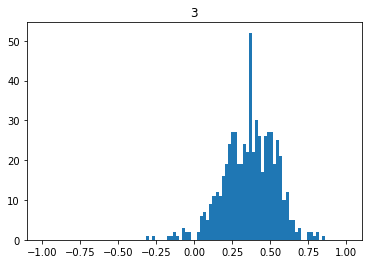

0.49729133


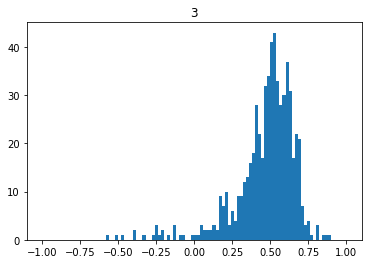

0.11916


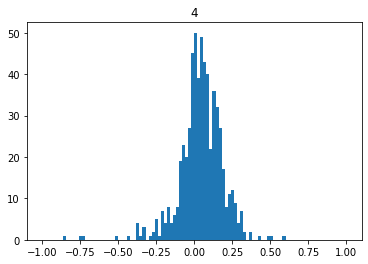

0.30959007


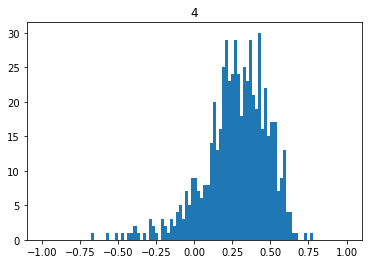

0.39431167


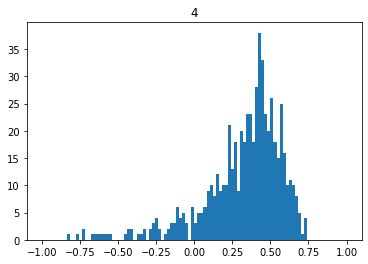

In [10]:
for i in range(len(Data.obs_label)):
    obs = Data.obs_label[i].copy()
    fine_l = Data.finetune_label[i].copy()
    ctm_l = Data.label[i].copy()
    
    obs[Data.obs_label[i]==-999] = 0
    fine_l[Data.obs_label[i]==-999] = 0
    ctm_l[Data.obs_label[i]==-999] = 0
    
    obs = np.sum(obs,axis = 0)
    fine_l = np.sum(fine_l,axis = 0)
    ctm_l = np.sum(ctm_l,axis = 0)

    a = (obs-fine_l)/(obs+1e-3)
    b = (fine_l-ctm_l)/(obs+1e-3)
    c = (obs-ctm_l)/(obs+1e-3)
    
    print(np.mean(np.abs(a[a!=0])))
    plt.hist(a[a!=0].reshape(-1),range=(-1,1),bins = 100)
    plt.title(i)
    plt.show()
    
    plt.hist(b[b!=0].reshape(-1),range=(-1,1),bins = 100)
    print(np.mean(np.abs(b[b!=0])))
    plt.title(i)
    plt.show()
    
    plt.hist(c[c!=0].reshape(-1),range=(-1,1),bins = 100)
    print(np.mean(np.abs(c[c!=0])))
    plt.title(i)
    plt.show()

In [8]:
print(1)

1


In [31]:
string = '''2020-01-09 02:00:19,619 : -----------85-----------
2020-02-10 04:17:14,195 : -----------1-----------
2020-02-10 04:18:52,588 : -----------1-----------
2020-02-10 04:21:09,552 : epoch 1 cur loss 6.208492279052734
2020-02-10 04:23:26,934 : epoch 1 cur loss 5.018283843994141
2020-02-10 04:25:44,031 : epoch 1 cur loss 4.533339023590088
2020-02-10 04:26:33,225 : epoch 1 cur loss 4.42041540145874
2020-02-10 04:28:31,398 : -------------cur test loss L1:  3.358869791030884
2020-02-10 04:28:31,398 : -----------2-----------
2020-02-10 04:30:48,267 : epoch 2 cur loss 3.3837618827819824
2020-02-10 04:33:05,177 : epoch 2 cur loss 3.3419721126556396
2020-02-10 04:35:22,245 : epoch 2 cur loss 3.308359384536743
2020-02-10 04:36:11,396 : epoch 2 cur loss 3.2946958541870117
2020-02-10 04:38:09,414 : -------------cur test loss L1:  3.2966396808624268
2020-02-10 04:38:09,414 : -----------3-----------
2020-02-10 04:40:26,662 : epoch 3 cur loss 3.1640567779541016
2020-02-10 04:42:43,721 : epoch 3 cur loss 3.152400016784668
2020-02-10 04:45:00,661 : epoch 3 cur loss 3.130884885787964
2020-02-10 04:45:50,022 : epoch 3 cur loss 3.1161270141601562
2020-02-10 04:47:47,946 : -------------cur test loss L1:  3.025149345397949
2020-02-10 04:47:47,947 : -----------4-----------
2020-02-10 04:50:05,065 : epoch 4 cur loss 3.0001003742218018
2020-02-10 04:52:22,085 : epoch 4 cur loss 2.977891445159912
2020-02-10 04:54:39,224 : epoch 4 cur loss 2.9724903106689453
2020-02-10 04:55:28,425 : epoch 4 cur loss 2.96563720703125
2020-02-10 04:57:25,574 : -------------cur test loss L1:  3.0188703536987305
2020-02-10 04:57:25,574 : -----------5-----------
2020-02-10 04:59:42,483 : epoch 5 cur loss 2.916017532348633
2020-02-10 05:01:59,757 : epoch 5 cur loss 2.904031276702881
2020-02-10 05:04:16,881 : epoch 5 cur loss 2.900691032409668
2020-02-10 05:05:06,234 : epoch 5 cur loss 2.89338755607605
2020-02-10 05:07:04,660 : -------------cur test loss L1:  2.931881904602051
2020-02-10 05:07:04,728 : -----------6-----------
2020-02-10 05:09:21,965 : epoch 6 cur loss 2.8397815227508545
2020-02-10 05:11:39,008 : epoch 6 cur loss 2.8042197227478027
2020-02-10 05:13:56,236 : epoch 6 cur loss 2.79805850982666
2020-02-10 05:14:45,555 : epoch 6 cur loss 2.799067974090576
2020-02-10 05:16:43,173 : -------------cur test loss L1:  2.928449869155884
2020-02-10 05:16:43,173 : -----------7-----------
2020-02-10 05:19:00,045 : epoch 7 cur loss 2.750631093978882
2020-02-10 05:21:17,042 : epoch 7 cur loss 2.749678373336792
2020-02-10 05:23:34,170 : epoch 7 cur loss 2.727116584777832
2020-02-10 05:24:23,452 : epoch 7 cur loss 2.7199630737304688
2020-02-10 05:26:21,141 : -------------cur test loss L1:  2.784907102584839
2020-02-10 05:26:21,141 : -----------8-----------
2020-02-10 05:28:38,119 : epoch 8 cur loss 2.68583607673645
2020-02-10 05:30:55,111 : epoch 8 cur loss 2.6832475662231445
2020-02-10 05:33:12,056 : epoch 8 cur loss 2.6641533374786377
2020-02-10 05:34:01,346 : epoch 8 cur loss 2.6629064083099365
2020-02-10 05:35:58,790 : -------------cur test loss L1:  2.7607438564300537
2020-02-10 05:35:58,790 : -----------9-----------
2020-02-10 05:38:15,578 : epoch 9 cur loss 2.6248886585235596
2020-02-10 05:40:32,528 : epoch 9 cur loss 2.628173828125
2020-02-10 05:42:49,383 : epoch 9 cur loss 2.6198368072509766
2020-02-10 05:43:38,717 : epoch 9 cur loss 2.6176486015319824
2020-02-10 05:45:36,609 : -------------cur test loss L1:  2.827610731124878
2020-02-10 05:45:36,609 : -----------10-----------
2020-02-10 05:47:53,396 : epoch 10 cur loss 2.5582282543182373
2020-02-10 05:50:10,413 : epoch 10 cur loss 2.5617969036102295
2020-02-10 05:52:27,243 : epoch 10 cur loss 2.545816659927368
2020-02-10 05:53:16,371 : epoch 10 cur loss 2.54058837890625
2020-02-10 05:55:13,393 : -------------cur test loss L1:  2.6743078231811523
2020-02-10 05:55:13,413 : -----------11-----------
2020-02-10 05:57:30,375 : epoch 11 cur loss 2.5282132625579834
2020-02-10 05:59:47,236 : epoch 11 cur loss 2.5155887603759766
2020-02-10 06:02:04,301 : epoch 11 cur loss 2.497243642807007
2020-02-10 06:02:53,418 : epoch 11 cur loss 2.499302864074707
2020-02-10 06:04:51,094 : -------------cur test loss L1:  2.6435916423797607
2020-02-10 06:04:51,094 : -----------12-----------
2020-02-10 06:07:07,970 : epoch 12 cur loss 2.4518704414367676
2020-02-10 06:09:24,821 : epoch 12 cur loss 2.4353270530700684
2020-02-10 06:11:41,830 : epoch 12 cur loss 2.4240331649780273
2020-02-10 06:12:30,982 : epoch 12 cur loss 2.4230477809906006
2020-02-10 06:14:28,537 : -------------cur test loss L1:  2.6226983070373535
2020-02-10 06:14:28,538 : -----------13-----------
2020-02-10 06:16:45,588 : epoch 13 cur loss 2.4317808151245117
2020-02-10 06:19:02,697 : epoch 13 cur loss 2.407217502593994
2020-02-10 06:21:19,470 : epoch 13 cur loss 2.400853157043457
2020-02-10 06:22:08,630 : epoch 13 cur loss 2.398366928100586
2020-02-10 06:24:06,022 : -------------cur test loss L1:  2.5793890953063965
2020-02-10 06:24:06,022 : -----------14-----------
2020-02-10 06:26:23,434 : epoch 14 cur loss 2.344460964202881
2020-02-10 06:28:40,754 : epoch 14 cur loss 2.3582048416137695
2020-02-10 06:30:57,831 : epoch 14 cur loss 2.3544328212738037
2020-02-10 06:31:47,053 : epoch 14 cur loss 2.3501644134521484
2020-02-10 06:33:44,722 : -------------cur test loss L1:  2.5039620399475098
2020-02-10 06:33:44,722 : -----------15-----------
2020-02-10 06:36:01,727 : epoch 15 cur loss 2.3140180110931396
2020-02-10 06:38:18,869 : epoch 15 cur loss 2.317276954650879
2020-02-10 06:40:35,786 : epoch 15 cur loss 2.3079004287719727
2020-02-10 06:41:24,884 : epoch 15 cur loss 2.310889720916748
2020-02-10 06:43:22,193 : -------------cur test loss L1:  2.566239595413208
2020-02-10 06:43:22,212 : -----------16-----------
2020-02-10 06:45:39,174 : epoch 16 cur loss 2.3023874759674072
2020-02-10 06:47:56,293 : epoch 16 cur loss 2.298218011856079
2020-02-10 06:50:13,659 : epoch 16 cur loss 2.2899227142333984
2020-02-10 06:51:02,717 : epoch 16 cur loss 2.287020683288574
2020-02-10 06:53:00,576 : -------------cur test loss L1:  2.5853404998779297
2020-02-10 06:53:00,577 : -----------17-----------
2020-02-10 06:55:17,651 : epoch 17 cur loss 2.249863386154175
2020-02-10 06:57:34,569 : epoch 17 cur loss 2.258232355117798
2020-02-10 06:59:51,316 : epoch 17 cur loss 2.253901481628418
2020-02-10 07:00:40,595 : epoch 17 cur loss 2.2485663890838623
2020-02-10 07:02:38,011 : -------------cur test loss L1:  2.4710710048675537
2020-02-10 07:02:38,012 : -----------18-----------
2020-02-10 07:04:55,065 : epoch 18 cur loss 2.2233235836029053
2020-02-10 07:07:12,072 : epoch 18 cur loss 2.2104384899139404
2020-02-10 07:09:28,807 : epoch 18 cur loss 2.218118190765381
2020-02-10 07:10:17,929 : epoch 18 cur loss 2.2185752391815186
2020-02-10 07:12:15,106 : -------------cur test loss L1:  2.4650511741638184
2020-02-10 07:12:15,106 : -----------19-----------
2020-02-10 07:14:32,081 : epoch 19 cur loss 2.200848340988159
2020-02-10 07:16:49,067 : epoch 19 cur loss 2.1992275714874268
2020-02-10 07:19:05,806 : epoch 19 cur loss 2.190901756286621
2020-02-10 07:19:54,935 : epoch 19 cur loss 2.1963016986846924
2020-02-10 07:21:52,209 : -------------cur test loss L1:  2.459066867828369
2020-02-10 07:21:52,209 : -----------20-----------
2020-02-10 07:24:09,081 : epoch 20 cur loss 2.152768135070801
2020-02-10 07:26:26,171 : epoch 20 cur loss 2.1532444953918457
2020-02-10 07:28:42,905 : epoch 20 cur loss 2.160585641860962
2020-02-10 07:29:32,077 : epoch 20 cur loss 2.1634647846221924
2020-02-10 07:31:29,196 : -------------cur test loss L1:  2.491321086883545
2020-02-10 07:31:29,216 : -----------21-----------
2020-02-10 07:33:45,950 : epoch 21 cur loss 2.1310009956359863
2020-02-10 07:36:02,940 : epoch 21 cur loss 2.1367156505584717
2020-02-10 07:38:19,627 : epoch 21 cur loss 2.134702444076538
2020-02-10 07:39:08,643 : epoch 21 cur loss 2.139465808868408
2020-02-10 07:41:05,748 : -------------cur test loss L1:  2.438997268676758
2020-02-10 07:41:05,748 : -----------22-----------
2020-02-10 07:43:22,948 : epoch 22 cur loss 2.1402242183685303
2020-02-10 07:45:40,025 : epoch 22 cur loss 2.136044502258301
2020-02-10 07:47:57,030 : epoch 22 cur loss 2.125871181488037
2020-02-10 07:48:46,124 : epoch 22 cur loss 2.1248672008514404
2020-02-10 07:50:43,396 : -------------cur test loss L1:  2.4444873332977295
2020-02-10 07:50:43,396 : -----------23-----------
2020-02-10 07:53:00,516 : epoch 23 cur loss 2.1149110794067383
2020-02-10 07:55:17,798 : epoch 23 cur loss 2.109031915664673
2020-02-10 07:57:34,612 : epoch 23 cur loss 2.1043665409088135
2020-02-10 07:58:23,630 : epoch 23 cur loss 2.101576328277588
2020-02-10 08:00:21,106 : -------------cur test loss L1:  2.4032392501831055
2020-02-10 08:00:21,106 : -----------24-----------
2020-02-10 08:02:38,093 : epoch 24 cur loss 2.068479537963867
2020-02-10 08:04:55,422 : epoch 24 cur loss 2.071687698364258
2020-02-10 08:07:12,420 : epoch 24 cur loss 2.075469970703125
2020-02-10 08:08:01,441 : epoch 24 cur loss 2.081498861312866
2020-02-10 08:09:59,397 : -------------cur test loss L1:  2.415404796600342
2020-02-10 08:09:59,397 : -----------25-----------
2020-02-10 08:12:16,678 : epoch 25 cur loss 2.047368049621582
2020-02-10 08:14:33,709 : epoch 25 cur loss 2.050459384918213
2020-02-10 08:16:50,718 : epoch 25 cur loss 2.057363748550415
2020-02-10 08:17:39,899 : epoch 25 cur loss 2.058741331100464
2020-02-10 08:19:37,821 : -------------cur test loss L1:  2.401548385620117
2020-02-10 08:19:37,841 : -----------26-----------
2020-02-10 08:21:54,993 : epoch 26 cur loss 2.0381553173065186
2020-02-10 08:24:12,161 : epoch 26 cur loss 2.0414774417877197
2020-02-10 08:26:29,293 : epoch 26 cur loss 2.0448873043060303
2020-02-10 08:27:18,382 : epoch 26 cur loss 2.042546272277832
2020-02-10 08:29:15,930 : -------------cur test loss L1:  2.4352848529815674
2020-02-10 08:29:15,931 : -----------27-----------
2020-02-10 08:31:32,826 : epoch 27 cur loss 2.009843349456787
2020-02-10 08:33:49,805 : epoch 27 cur loss 2.022012233734131
2020-02-10 08:36:06,751 : epoch 27 cur loss 2.021984100341797
2020-02-10 08:36:55,994 : epoch 27 cur loss 2.017699718475342
2020-02-10 08:38:53,882 : -------------cur test loss L1:  2.36053466796875
2020-02-10 08:38:53,882 : -----------28-----------
2020-02-10 08:41:10,753 : epoch 28 cur loss 2.0010550022125244
2020-02-10 08:43:27,583 : epoch 28 cur loss 2.0167768001556396
2020-02-10 08:45:44,445 : epoch 28 cur loss 2.0054092407226562
2020-02-10 08:46:33,641 : epoch 28 cur loss 2.005178689956665
2020-02-10 08:48:31,049 : -------------cur test loss L1:  2.6486196517944336
2020-02-10 08:48:31,049 : -----------29-----------
2020-02-10 08:50:47,746 : epoch 29 cur loss 2.0149786472320557
2020-02-10 08:53:04,731 : epoch 29 cur loss 1.997225284576416
2020-02-10 08:55:21,903 : epoch 29 cur loss 1.9882129430770874
2020-02-10 08:56:11,139 : epoch 29 cur loss 1.9900494813919067
2020-02-10 08:58:08,531 : -------------cur test loss L1:  2.485868215560913
2020-02-10 08:58:08,531 : -----------30-----------
2020-02-10 09:00:25,571 : epoch 30 cur loss 1.9587271213531494
2020-02-10 09:02:42,551 : epoch 30 cur loss 1.9656665325164795
2020-02-10 09:04:59,375 : epoch 30 cur loss 1.9654052257537842
2020-02-10 09:05:48,555 : epoch 30 cur loss 1.970384120941162
2020-02-10 09:07:47,144 : -------------cur test loss L1:  2.367539882659912
2020-02-10 09:07:47,167 : -----------31-----------
2020-02-10 09:10:04,221 : epoch 31 cur loss 1.9989782571792603
2020-02-10 09:12:21,855 : epoch 31 cur loss 1.9760931730270386
2020-02-10 09:14:38,962 : epoch 31 cur loss 1.9661327600479126
2020-02-10 09:15:28,163 : epoch 31 cur loss 1.9584728479385376
2020-02-10 09:17:25,523 : -------------cur test loss L1:  2.3164544105529785
2020-02-10 09:17:25,523 : -----------32-----------
2020-02-10 09:19:42,921 : epoch 32 cur loss 1.938979148864746
2020-02-10 09:21:59,922 : epoch 32 cur loss 1.9454118013381958
2020-02-10 09:24:17,197 : epoch 32 cur loss 1.9489994049072266
2020-02-10 09:25:06,370 : epoch 32 cur loss 1.9474467039108276
2020-02-10 09:27:03,802 : -------------cur test loss L1:  2.321881055831909
2020-02-10 09:27:03,802 : -----------33-----------
2020-02-10 09:29:21,122 : epoch 33 cur loss 1.9105900526046753
2020-02-10 09:31:38,074 : epoch 33 cur loss 1.9193655252456665
2020-02-10 09:33:54,811 : epoch 33 cur loss 1.927404761314392
2020-02-10 09:34:44,177 : epoch 33 cur loss 1.9226833581924438
2020-02-10 09:36:41,649 : -------------cur test loss L1:  2.418095350265503
2020-02-10 09:36:41,649 : -----------34-----------
2020-02-10 09:38:58,710 : epoch 34 cur loss 1.9100419282913208
2020-02-10 09:41:15,940 : epoch 34 cur loss 1.914334774017334
2020-02-10 09:43:33,129 : epoch 34 cur loss 1.9134244918823242
2020-02-10 09:44:22,192 : epoch 34 cur loss 1.9106428623199463
2020-02-10 09:46:19,602 : -------------cur test loss L1:  2.3189117908477783
2020-02-10 09:46:19,602 : -----------35-----------
2020-02-10 09:48:36,879 : epoch 35 cur loss 1.9105840921401978
2020-02-10 09:50:54,001 : epoch 35 cur loss 1.9069732427597046
2020-02-10 09:53:11,206 : epoch 35 cur loss 1.9086681604385376
2020-02-10 09:54:00,457 : epoch 35 cur loss 1.9061696529388428
2020-02-10 09:55:58,252 : -------------cur test loss L1:  2.30329966545105
2020-02-10 09:55:58,271 : -----------36-----------
2020-02-10 09:58:15,558 : epoch 36 cur loss 1.8993327617645264
2020-02-10 10:00:33,127 : epoch 36 cur loss 1.9033796787261963
2020-02-10 10:02:49,977 : epoch 36 cur loss 1.8999910354614258
2020-02-10 10:03:39,104 : epoch 36 cur loss 1.900201678276062
2020-02-10 10:05:37,075 : -------------cur test loss L1:  2.3864121437072754
2020-02-10 10:05:37,075 : -----------37-----------
2020-02-10 10:07:54,257 : epoch 37 cur loss 1.8952994346618652
2020-02-10 10:10:11,676 : epoch 37 cur loss 1.8936212062835693
2020-02-10 10:12:28,865 : epoch 37 cur loss 1.8851847648620605
2020-02-10 10:13:18,269 : epoch 37 cur loss 1.8824081420898438
2020-02-10 10:15:15,862 : -------------cur test loss L1:  2.329357624053955
2020-02-10 10:15:15,862 : -----------38-----------
2020-02-10 10:17:33,035 : epoch 38 cur loss 1.8611884117126465
2020-02-10 10:19:50,491 : epoch 38 cur loss 1.8714724779129028
2020-02-10 10:22:07,747 : epoch 38 cur loss 1.8740499019622803
2020-02-10 10:22:56,767 : epoch 38 cur loss 1.8719373941421509
2020-02-10 10:24:54,670 : -------------cur test loss L1:  2.2631757259368896
2020-02-10 10:24:54,670 : -----------39-----------
2020-02-10 10:27:11,979 : epoch 39 cur loss 1.8606665134429932
2020-02-10 10:29:29,301 : epoch 39 cur loss 1.8554108142852783
2020-02-10 10:31:46,528 : epoch 39 cur loss 1.859748125076294
2020-02-10 10:32:35,630 : epoch 39 cur loss 1.862998604774475
2020-02-10 10:34:32,567 : -------------cur test loss L1:  2.3131749629974365
2020-02-10 10:34:32,567 : -----------40-----------
2020-02-10 10:36:50,024 : epoch 40 cur loss 1.8574395179748535
2020-02-10 10:39:06,679 : epoch 40 cur loss 1.8489162921905518
2020-02-10 10:41:23,706 : epoch 40 cur loss 1.8410860300064087
2020-02-10 10:42:12,899 : epoch 40 cur loss 1.8458040952682495
2020-02-10 10:44:11,190 : -------------cur test loss L1:  2.3471016883850098
2020-02-10 10:44:11,210 : -----------41-----------
2020-02-10 10:46:28,403 : epoch 41 cur loss 1.8487253189086914
2020-02-10 10:48:45,584 : epoch 41 cur loss 1.845090389251709
2020-02-10 10:51:02,596 : epoch 41 cur loss 1.844969630241394
2020-02-10 10:51:52,019 : epoch 41 cur loss 1.8464215993881226
2020-02-10 10:53:49,757 : -------------cur test loss L1:  2.2688100337982178
2020-02-10 10:53:49,757 : -----------42-----------
2020-02-10 10:56:06,783 : epoch 42 cur loss 1.8181289434432983
2020-02-10 10:58:24,182 : epoch 42 cur loss 1.8371641635894775
2020-02-10 11:00:42,138 : epoch 42 cur loss 1.830586552619934
2020-02-10 11:01:31,429 : epoch 42 cur loss 1.8336392641067505
2020-02-10 11:03:28,928 : -------------cur test loss L1:  2.3922510147094727
2020-02-10 11:03:28,928 : -----------43-----------
2020-02-10 11:05:46,197 : epoch 43 cur loss 1.8051873445510864
2020-02-10 11:08:03,330 : epoch 43 cur loss 1.8091682195663452
2020-02-10 11:10:20,291 : epoch 43 cur loss 1.8148771524429321
2020-02-10 11:11:09,622 : epoch 43 cur loss 1.8179070949554443
2020-02-10 11:13:07,098 : -------------cur test loss L1:  2.25634503364563
2020-02-10 11:13:07,098 : -----------44-----------
2020-02-10 11:15:24,053 : epoch 44 cur loss 1.827639102935791
2020-02-10 11:17:40,791 : epoch 44 cur loss 1.8291414976119995
2020-02-10 11:19:57,778 : epoch 44 cur loss 1.8253473043441772
2020-02-10 11:20:47,048 : epoch 44 cur loss 1.8199968338012695
2020-02-10 11:22:44,025 : -------------cur test loss L1:  2.3205642700195312
2020-02-10 11:22:44,025 : -----------45-----------
2020-02-10 11:25:00,942 : epoch 45 cur loss 1.8152008056640625
2020-02-10 11:27:17,883 : epoch 45 cur loss 1.808278203010559
2020-02-10 11:29:34,764 : epoch 45 cur loss 1.8149574995040894
2020-02-10 11:30:23,725 : epoch 45 cur loss 1.8137106895446777
2020-02-10 11:32:21,278 : -------------cur test loss L1:  2.2540180683135986
2020-02-10 11:32:21,298 : -----------46-----------
2020-02-10 11:34:38,584 : epoch 46 cur loss 1.786289930343628
2020-02-10 11:36:55,656 : epoch 46 cur loss 1.7996701002120972
2020-02-10 11:39:13,273 : epoch 46 cur loss 1.800093173980713
2020-02-10 11:40:02,559 : epoch 46 cur loss 1.8039519786834717
2020-02-10 11:42:00,287 : -------------cur test loss L1:  2.271350145339966
2020-02-10 11:42:00,287 : -----------47-----------
2020-02-10 11:44:17,064 : epoch 47 cur loss 1.7876200675964355
2020-02-10 11:46:34,088 : epoch 47 cur loss 1.787520408630371
2020-02-10 11:48:50,918 : epoch 47 cur loss 1.7875994443893433
2020-02-10 11:49:39,983 : epoch 47 cur loss 1.7866472005844116
2020-02-10 11:51:37,355 : -------------cur test loss L1:  2.2845497131347656
2020-02-10 11:51:37,355 : -----------48-----------
2020-02-10 11:53:54,420 : epoch 48 cur loss 1.7741702795028687
2020-02-10 11:56:11,457 : epoch 48 cur loss 1.7731918096542358
2020-02-10 11:58:28,265 : epoch 48 cur loss 1.7773860692977905
2020-02-10 11:59:17,454 : epoch 48 cur loss 1.7782586812973022
2020-02-10 12:01:15,079 : -------------cur test loss L1:  2.3905398845672607
2020-02-10 12:01:15,079 : -----------49-----------
2020-02-10 12:03:31,957 : epoch 49 cur loss 1.7850124835968018
2020-02-10 12:05:48,533 : epoch 49 cur loss 1.7792282104492188
2020-02-10 12:08:05,327 : epoch 49 cur loss 1.7799057960510254
2020-02-10 12:08:54,474 : epoch 49 cur loss 1.7776923179626465
2020-02-10 12:10:52,633 : -------------cur test loss L1:  2.2875843048095703
2020-02-10 12:10:52,633 : -----------50-----------
2020-02-10 12:13:09,861 : epoch 50 cur loss 1.7704930305480957
2020-02-10 12:15:26,657 : epoch 50 cur loss 1.7757998704910278
2020-02-10 12:17:43,766 : epoch 50 cur loss 1.7747066020965576
2020-02-10 12:18:32,937 : epoch 50 cur loss 1.7751599550247192
2020-02-10 12:20:30,425 : -------------cur test loss L1:  2.283651828765869
2020-02-10 12:20:30,444 : -----------51-----------
2020-02-10 12:22:47,336 : epoch 51 cur loss 1.756553292274475
2020-02-10 12:25:04,309 : epoch 51 cur loss 1.7563714981079102
2020-02-10 12:27:21,448 : epoch 51 cur loss 1.7604784965515137
2020-02-10 12:28:10,557 : epoch 51 cur loss 1.7591711282730103
2020-02-10 12:30:08,495 : -------------cur test loss L1:  2.2477455139160156
2020-02-10 12:30:08,496 : -----------52-----------
2020-02-10 12:32:25,881 : epoch 52 cur loss 1.760977029800415
2020-02-10 12:34:42,852 : epoch 52 cur loss 1.7607454061508179
2020-02-10 12:36:59,736 : epoch 52 cur loss 1.757812261581421
2020-02-10 12:37:48,892 : epoch 52 cur loss 1.7632391452789307
2020-02-10 12:39:45,845 : -------------cur test loss L1:  2.3888490200042725
2020-02-10 12:39:45,845 : -----------53-----------
2020-02-10 12:42:02,944 : epoch 53 cur loss 1.7359713315963745
2020-02-10 12:44:20,036 : epoch 53 cur loss 1.7396091222763062
2020-02-10 12:46:37,286 : epoch 53 cur loss 1.7480826377868652
2020-02-10 12:47:26,663 : epoch 53 cur loss 1.7499128580093384
2020-02-10 12:49:24,460 : -------------cur test loss L1:  2.2772650718688965
2020-02-10 12:49:24,460 : -----------54-----------
2020-02-10 12:51:41,391 : epoch 54 cur loss 1.7390943765640259
2020-02-10 12:53:58,595 : epoch 54 cur loss 1.7520835399627686
2020-02-10 12:56:15,503 : epoch 54 cur loss 1.7539422512054443
2020-02-10 12:57:04,726 : epoch 54 cur loss 1.7514114379882812
2020-02-10 12:59:02,074 : -------------cur test loss L1:  2.35649037361145
2020-02-10 12:59:02,074 : -----------55-----------
2020-02-10 13:01:19,235 : epoch 55 cur loss 1.7385519742965698
2020-02-10 13:03:36,122 : epoch 55 cur loss 1.7420501708984375
2020-02-10 13:05:52,802 : epoch 55 cur loss 1.7426449060440063
2020-02-10 13:06:41,954 : epoch 55 cur loss 1.739978551864624
2020-02-10 13:08:39,112 : -------------cur test loss L1:  2.2969696521759033
2020-02-10 13:08:39,131 : -----------56-----------
2020-02-10 13:10:55,927 : epoch 56 cur loss 1.7278337478637695
2020-02-10 13:13:13,010 : epoch 56 cur loss 1.7271740436553955
2020-02-10 13:15:34,058 : epoch 56 cur loss 1.731726884841919
2020-02-10 13:16:28,425 : epoch 56 cur loss 1.734013557434082
2020-02-10 13:18:55,736 : -------------cur test loss L1:  2.3524258136749268
2020-02-10 13:18:55,736 : -----------57-----------
2020-02-10 13:21:33,118 : epoch 57 cur loss 1.7199581861495972
2020-02-10 13:24:10,247 : epoch 57 cur loss 1.7343612909317017
2020-02-10 13:26:47,535 : epoch 57 cur loss 1.7253490686416626
2020-02-10 13:27:43,835 : epoch 57 cur loss 1.7246578931808472
2020-02-10 13:30:10,958 : -------------cur test loss L1:  2.3049380779266357
2020-02-10 13:30:10,958 : -----------58-----------
2020-02-10 13:32:47,774 : epoch 58 cur loss 1.7485854625701904
2020-02-10 13:35:25,005 : epoch 58 cur loss 1.734582543373108
2020-02-10 13:38:01,510 : epoch 58 cur loss 1.7237422466278076
2020-02-10 13:38:57,632 : epoch 58 cur loss 1.7237979173660278
2020-02-10 13:41:24,861 : -------------cur test loss L1:  2.2721948623657227
2020-02-10 13:41:24,861 : -----------59-----------
2020-02-10 13:44:01,617 : epoch 59 cur loss 1.7567657232284546
2020-02-10 13:46:38,293 : epoch 59 cur loss 1.7381786108016968
2020-02-10 13:49:14,894 : epoch 59 cur loss 1.7285152673721313
2020-02-10 13:50:11,167 : epoch 59 cur loss 1.7253590822219849
2020-02-10 13:52:39,418 : -------------cur test loss L1:  2.2755866050720215
2020-02-10 13:52:39,419 : -----------60-----------
2020-02-10 13:55:16,276 : epoch 60 cur loss 1.7199985980987549
2020-02-10 13:57:53,156 : epoch 60 cur loss 1.715675950050354
2020-02-10 14:00:30,264 : epoch 60 cur loss 1.713341474533081
2020-02-10 14:01:26,505 : epoch 60 cur loss 1.7138334512710571
2020-02-10 14:03:53,774 : -------------cur test loss L1:  2.2383229732513428
2020-02-10 14:03:53,793 : -----------61-----------
2020-02-10 14:06:31,408 : epoch 61 cur loss 1.6959537267684937
2020-02-10 14:09:07,957 : epoch 61 cur loss 1.7038748264312744
2020-02-10 14:11:43,636 : epoch 61 cur loss 1.708001732826233
2020-02-10 14:12:39,535 : epoch 61 cur loss 1.709688425064087
2020-02-10 14:15:04,195 : -------------cur test loss L1:  2.4405484199523926
2020-02-10 14:15:04,195 : -----------62-----------
2020-02-10 14:17:37,749 : epoch 62 cur loss 1.7020138502120972
2020-02-10 14:20:11,514 : epoch 62 cur loss 1.6967930793762207
2020-02-10 14:22:45,056 : epoch 62 cur loss 1.7050060033798218
2020-02-10 14:23:40,482 : epoch 62 cur loss 1.704362392425537
2020-02-10 14:26:03,271 : -------------cur test loss L1:  2.2285404205322266
2020-02-10 14:26:03,272 : -----------63-----------
2020-02-10 14:28:36,506 : epoch 63 cur loss 1.6854901313781738
2020-02-10 14:31:09,899 : epoch 63 cur loss 1.6959118843078613
2020-02-10 14:33:43,123 : epoch 63 cur loss 1.6926610469818115
2020-02-10 14:34:38,542 : epoch 63 cur loss 1.6922380924224854
2020-02-10 14:37:01,976 : -------------cur test loss L1:  2.274634838104248
2020-02-10 14:37:01,976 : -----------64-----------
2020-02-10 14:39:34,917 : epoch 64 cur loss 1.6996705532073975
2020-02-10 14:42:08,137 : epoch 64 cur loss 1.6828579902648926
2020-02-10 14:44:41,551 : epoch 64 cur loss 1.6908257007598877
2020-02-10 14:45:36,466 : epoch 64 cur loss 1.6926110982894897
2020-02-10 14:47:58,188 : -------------cur test loss L1:  2.24908185005188
2020-02-10 14:47:58,188 : -----------65-----------
2020-02-10 14:50:30,731 : epoch 65 cur loss 1.6768969297409058
2020-02-10 14:53:03,711 : epoch 65 cur loss 1.6892200708389282
2020-02-10 14:55:35,858 : epoch 65 cur loss 1.690019130706787
2020-02-10 14:56:30,315 : epoch 65 cur loss 1.6909509897232056
2020-02-10 14:58:51,045 : -------------cur test loss L1:  2.268073797225952
2020-02-10 14:58:51,065 : -----------66-----------
2020-02-10 15:01:22,570 : epoch 66 cur loss 1.676979422569275
2020-02-10 15:03:53,225 : epoch 66 cur loss 1.6874090433120728
2020-02-10 15:06:23,750 : epoch 66 cur loss 1.6823437213897705
2020-02-10 15:07:18,084 : epoch 66 cur loss 1.6810073852539062
2020-02-10 15:09:38,104 : -------------cur test loss L1:  2.2411890029907227
2020-02-10 15:09:38,105 : -----------67-----------
2020-02-10 15:12:08,921 : epoch 67 cur loss 1.6613038778305054
2020-02-10 15:14:39,020 : epoch 67 cur loss 1.670607566833496
2020-02-10 15:17:09,295 : epoch 67 cur loss 1.675531029701233
2020-02-10 15:18:03,365 : epoch 67 cur loss 1.6757115125656128
2020-02-10 15:20:22,488 : -------------cur test loss L1:  2.22057843208313
2020-02-10 15:20:22,488 : -----------68-----------
2020-02-10 15:22:52,493 : epoch 68 cur loss 1.6565523147583008
2020-02-10 15:25:22,608 : epoch 68 cur loss 1.6620419025421143
2020-02-10 15:27:52,424 : epoch 68 cur loss 1.6713703870773315
2020-02-10 15:28:46,343 : epoch 68 cur loss 1.6709345579147339
2020-02-10 15:31:04,799 : -------------cur test loss L1:  2.2479894161224365
2020-02-10 15:31:04,799 : -----------69-----------
2020-02-10 15:33:35,242 : epoch 69 cur loss 1.657281756401062
2020-02-10 15:36:05,753 : epoch 69 cur loss 1.665230393409729
2020-02-10 15:38:36,114 : epoch 69 cur loss 1.6636321544647217
2020-02-10 15:39:30,002 : epoch 69 cur loss 1.6660176515579224
2020-02-10 15:41:48,409 : -------------cur test loss L1:  2.2371609210968018
2020-02-10 15:41:48,409 : -----------70-----------
2020-02-10 15:44:18,478 : epoch 70 cur loss 1.6668912172317505
2020-02-10 15:46:48,549 : epoch 70 cur loss 1.6665006875991821
2020-02-10 15:49:18,910 : epoch 70 cur loss 1.6807063817977905
2020-02-10 15:50:13,183 : epoch 70 cur loss 1.6830124855041504
2020-02-10 15:52:33,374 : -------------cur test loss L1:  2.3314669132232666
2020-02-10 15:52:33,394 : -----------71-----------
2020-02-10 15:55:03,817 : epoch 71 cur loss 1.6478763818740845
2020-02-10 15:57:34,177 : epoch 71 cur loss 1.6503982543945312
2020-02-10 16:00:04,649 : epoch 71 cur loss 1.6524183750152588
2020-02-10 16:00:58,373 : epoch 71 cur loss 1.6512627601623535
2020-02-10 16:03:16,374 : -------------cur test loss L1:  2.42930269241333
2020-02-10 16:03:16,374 : -----------72-----------
2020-02-10 16:05:45,741 : epoch 72 cur loss 1.6968886852264404
2020-02-10 16:08:15,673 : epoch 72 cur loss 1.6631536483764648
2020-02-10 16:10:44,922 : epoch 72 cur loss 1.6620714664459229
2020-02-10 16:11:39,096 : epoch 72 cur loss 1.6646982431411743
2020-02-10 16:13:57,928 : -------------cur test loss L1:  2.2512283325195312
2020-02-10 16:13:57,928 : -----------73-----------
2020-02-10 16:16:27,158 : epoch 73 cur loss 1.6700979471206665
2020-02-10 16:18:56,929 : epoch 73 cur loss 1.6623749732971191
2020-02-10 16:21:26,650 : epoch 73 cur loss 1.656535029411316
2020-02-10 16:22:20,152 : epoch 73 cur loss 1.660093069076538
2020-02-10 16:24:38,666 : -------------cur test loss L1:  2.2293009757995605
2020-02-10 16:24:38,666 : -----------74-----------
2020-02-10 16:27:07,768 : epoch 74 cur loss 1.6337761878967285
2020-02-10 16:29:36,556 : epoch 74 cur loss 1.6401605606079102
2020-02-10 16:32:05,372 : epoch 74 cur loss 1.643517017364502
2020-02-10 16:32:59,001 : epoch 74 cur loss 1.6448026895523071
2020-02-10 16:35:16,544 : -------------cur test loss L1:  2.256566286087036
2020-02-10 16:35:16,545 : -----------75-----------
2020-02-10 16:37:46,142 : epoch 75 cur loss 1.6284756660461426
2020-02-10 16:40:15,249 : epoch 75 cur loss 1.6456656455993652
2020-02-10 16:42:44,213 : epoch 75 cur loss 1.6562786102294922
2020-02-10 16:43:37,615 : epoch 75 cur loss 1.6527308225631714
2020-02-10 16:45:54,907 : -------------cur test loss L1:  2.2178144454956055
2020-02-10 16:45:54,927 : -----------76-----------
2020-02-10 16:48:23,934 : epoch 76 cur loss 1.6345559358596802
2020-02-10 16:50:53,327 : epoch 76 cur loss 1.6395303010940552
2020-02-10 16:53:22,396 : epoch 76 cur loss 1.6361838579177856
2020-02-10 16:54:15,690 : epoch 76 cur loss 1.6335816383361816
2020-02-10 16:56:32,651 : -------------cur test loss L1:  2.225776195526123
2020-02-10 16:56:32,651 : -----------77-----------
2020-02-10 16:59:01,458 : epoch 77 cur loss 1.647711992263794
2020-02-10 17:01:29,232 : epoch 77 cur loss 1.6496871709823608
2020-02-10 17:03:58,383 : epoch 77 cur loss 1.6474096775054932
2020-02-10 17:04:51,647 : epoch 77 cur loss 1.6475229263305664
2020-02-10 17:07:08,905 : -------------cur test loss L1:  2.2781612873077393
2020-02-10 17:07:08,905 : -----------78-----------
2020-02-10 17:09:37,637 : epoch 78 cur loss 1.6368298530578613
2020-02-10 17:12:06,224 : epoch 78 cur loss 1.6347538232803345
2020-02-10 17:14:35,680 : epoch 78 cur loss 1.6425797939300537
2020-02-10 17:15:28,952 : epoch 78 cur loss 1.640289306640625
2020-02-10 17:17:47,206 : -------------cur test loss L1:  2.234590530395508
2020-02-10 17:17:47,206 : -----------79-----------
2020-02-10 17:20:15,625 : epoch 79 cur loss 1.6372158527374268
2020-02-10 17:22:44,222 : epoch 79 cur loss 1.6350973844528198
2020-02-10 17:25:13,218 : epoch 79 cur loss 1.6274691820144653
2020-02-10 17:26:06,291 : epoch 79 cur loss 1.628686785697937
2020-02-10 17:28:23,453 : -------------cur test loss L1:  2.253873825073242
2020-02-10 17:28:23,453 : -----------80-----------
2020-02-10 17:30:52,313 : epoch 80 cur loss 1.626171588897705
2020-02-10 17:33:20,804 : epoch 80 cur loss 1.6264625787734985
2020-02-10 17:35:49,201 : epoch 80 cur loss 1.6305307149887085
2020-02-10 17:36:42,466 : epoch 80 cur loss 1.6297868490219116
2020-02-10 17:39:01,095 : -------------cur test loss L1:  2.293283224105835
2020-02-10 17:39:01,118 : -----------81-----------
2020-02-10 17:41:29,452 : epoch 81 cur loss 1.6088402271270752
2020-02-10 17:43:57,895 : epoch 81 cur loss 1.6136664152145386
2020-02-10 17:46:26,256 : epoch 81 cur loss 1.6203159093856812
2020-02-10 17:47:19,653 : epoch 81 cur loss 1.6205291748046875
2020-02-10 17:49:37,119 : -------------cur test loss L1:  2.2616147994995117
2020-02-10 17:49:37,120 : -----------82-----------
2020-02-10 17:52:05,243 : epoch 82 cur loss 1.6118574142456055
2020-02-10 17:54:32,972 : epoch 82 cur loss 1.618959903717041
2020-02-10 17:57:00,734 : epoch 82 cur loss 1.6286120414733887
2020-02-10 17:57:53,694 : epoch 82 cur loss 1.6286001205444336
2020-02-10 18:00:10,611 : -------------cur test loss L1:  2.217036724090576
2020-02-10 18:00:10,611 : -----------83-----------
2020-02-10 18:02:38,658 : epoch 83 cur loss 1.6173397302627563
2020-02-10 18:05:06,512 : epoch 83 cur loss 1.617582082748413
2020-02-10 18:07:34,062 : epoch 83 cur loss 1.6136643886566162
2020-02-10 18:08:27,421 : epoch 83 cur loss 1.613489031791687
2020-02-10 18:10:43,572 : -------------cur test loss L1:  2.2157161235809326
2020-02-10 18:10:43,573 : -----------84-----------
2020-02-10 18:13:10,575 : epoch 84 cur loss 1.6006531715393066
2020-02-10 18:15:38,199 : epoch 84 cur loss 1.6220535039901733
2020-02-10 18:18:05,099 : epoch 84 cur loss 1.621269941329956
2020-02-10 18:18:57,791 : epoch 84 cur loss 1.6204897165298462
2020-02-10 18:21:15,014 : -------------cur test loss L1:  2.341822862625122
2020-02-10 18:21:15,014 : -----------85-----------
2020-02-10 18:23:42,282 : epoch 85 cur loss 1.6288402080535889
2020-02-10 18:26:09,365 : epoch 85 cur loss 1.6120721101760864
2020-02-10 18:28:36,001 : epoch 85 cur loss 1.610091209411621
2020-02-10 18:29:28,651 : epoch 85 cur loss 1.6133617162704468
2020-02-10 18:31:44,627 : -------------cur test loss L1:  2.2638680934906006
2020-02-10 18:31:44,646 : -----------86-----------
2020-02-10 18:34:11,521 : epoch 86 cur loss 1.6128568649291992
2020-02-10 18:36:37,953 : epoch 86 cur loss 1.609166145324707
2020-02-10 18:39:04,328 : epoch 86 cur loss 1.609102725982666
2020-02-10 18:39:56,856 : epoch 86 cur loss 1.6086658239364624
2020-02-10 18:42:12,611 : -------------cur test loss L1:  2.2163541316986084
2020-02-10 18:42:12,611 : -----------87-----------
2020-02-10 18:44:39,283 : epoch 87 cur loss 1.6023831367492676
2020-02-10 18:47:06,263 : epoch 87 cur loss 1.610475778579712
2020-02-10 18:49:32,969 : epoch 87 cur loss 1.6087992191314697
2020-02-10 18:50:25,331 : epoch 87 cur loss 1.6051712036132812
2020-02-10 18:52:41,399 : -------------cur test loss L1:  2.2391021251678467
2020-02-10 18:52:41,400 : -----------88-----------
2020-02-10 18:55:09,067 : epoch 88 cur loss 1.5890088081359863
2020-02-10 18:57:36,179 : epoch 88 cur loss 1.593882441520691
2020-02-10 19:00:03,714 : epoch 88 cur loss 1.6002447605133057
2020-02-10 19:00:56,214 : epoch 88 cur loss 1.6011247634887695
2020-02-10 19:03:12,600 : -------------cur test loss L1:  2.2310354709625244
2020-02-10 19:03:12,600 : -----------89-----------
2020-02-10 19:05:38,968 : epoch 89 cur loss 1.5866450071334839
2020-02-10 19:08:04,767 : epoch 89 cur loss 1.6020699739456177
2020-02-10 19:10:30,596 : epoch 89 cur loss 1.5985469818115234
2020-02-10 19:11:23,367 : epoch 89 cur loss 1.6007919311523438
2020-02-10 19:13:37,450 : -------------cur test loss L1:  2.296271324157715
2020-02-10 19:13:37,450 : -----------90-----------
2020-02-10 19:16:01,398 : epoch 90 cur loss 1.6106685400009155
2020-02-10 19:18:25,305 : epoch 90 cur loss 1.6018811464309692
2020-02-10 19:20:49,386 : epoch 90 cur loss 1.5985971689224243
2020-02-10 19:21:41,161 : epoch 90 cur loss 1.6012979745864868
2020-02-10 19:23:53,451 : -------------cur test loss L1:  2.2486252784729004
2020-02-10 19:23:53,478 : -----------91-----------
2020-02-10 19:26:17,722 : epoch 91 cur loss 1.5922435522079468
2020-02-10 19:28:42,233 : epoch 91 cur loss 1.5907678604125977
2020-02-10 19:31:06,533 : epoch 91 cur loss 1.5940940380096436
2020-02-10 19:31:58,531 : epoch 91 cur loss 1.5924208164215088
2020-02-10 19:34:10,498 : -------------cur test loss L1:  2.2266244888305664
2020-02-10 19:34:10,499 : -----------92-----------
2020-02-10 19:36:33,337 : epoch 92 cur loss 1.5966026782989502
2020-02-10 19:38:56,296 : epoch 92 cur loss 1.591331124305725
2020-02-10 19:41:19,527 : epoch 92 cur loss 1.5948981046676636
2020-02-10 19:42:10,890 : epoch 92 cur loss 1.5954877138137817
2020-02-10 19:44:24,224 : -------------cur test loss L1:  2.2178399562835693
2020-02-10 19:44:24,224 : -----------93-----------
2020-02-10 19:46:47,463 : epoch 93 cur loss 1.574155330657959
2020-02-10 19:49:10,810 : epoch 93 cur loss 1.5859079360961914
2020-02-10 19:51:34,033 : epoch 93 cur loss 1.5863468647003174
2020-02-10 19:52:25,173 : epoch 93 cur loss 1.5848236083984375
2020-02-10 19:54:36,866 : -------------cur test loss L1:  2.2386534214019775
2020-02-10 19:54:36,866 : -----------94-----------
2020-02-10 19:57:00,869 : epoch 94 cur loss 1.5922106504440308
2020-02-10 19:59:23,901 : epoch 94 cur loss 1.599766492843628
2020-02-10 20:01:47,188 : epoch 94 cur loss 1.6007882356643677
2020-02-10 20:02:38,655 : epoch 94 cur loss 1.5973118543624878
2020-02-10 20:04:51,451 : -------------cur test loss L1:  2.2197484970092773
2020-02-10 20:04:51,451 : -----------95-----------
2020-02-10 20:07:15,694 : epoch 95 cur loss 1.5620614290237427
2020-02-10 20:09:39,130 : epoch 95 cur loss 1.5707095861434937
2020-02-10 20:12:02,649 : epoch 95 cur loss 1.5822721719741821
2020-02-10 20:12:54,302 : epoch 95 cur loss 1.5807589292526245
2020-02-10 20:15:07,580 : -------------cur test loss L1:  2.2198970317840576
2020-02-10 20:15:07,601 : -----------96-----------
2020-02-10 20:17:31,179 : epoch 96 cur loss 1.58295476436615
2020-02-10 20:19:54,414 : epoch 96 cur loss 1.577884316444397
2020-02-10 20:22:16,860 : epoch 96 cur loss 1.5726438760757446
2020-02-10 20:23:08,334 : epoch 96 cur loss 1.5792163610458374
2020-02-10 20:25:21,110 : -------------cur test loss L1:  2.330627202987671
2020-02-10 20:25:21,110 : -----------97-----------
2020-02-10 20:27:44,712 : epoch 97 cur loss 1.5758652687072754
2020-02-10 20:30:08,435 : epoch 97 cur loss 1.5804319381713867
2020-02-10 20:32:32,883 : epoch 97 cur loss 1.580934762954712
2020-02-10 20:33:24,594 : epoch 97 cur loss 1.578460693359375
2020-02-10 20:35:37,719 : -------------cur test loss L1:  2.2361197471618652
2020-02-10 20:35:37,719 : -----------98-----------
2020-02-10 20:38:01,197 : epoch 98 cur loss 1.5783909559249878
2020-02-10 20:40:24,807 : epoch 98 cur loss 1.576765775680542
2020-02-10 20:42:48,893 : epoch 98 cur loss 1.5746248960494995
2020-02-10 20:43:40,106 : epoch 98 cur loss 1.5760318040847778
2020-02-10 20:45:51,849 : -------------cur test loss L1:  2.205594062805176
2020-02-10 20:45:51,849 : -----------99-----------
2020-02-10 20:48:14,555 : epoch 99 cur loss 1.5827889442443848
2020-02-10 20:50:37,545 : epoch 99 cur loss 1.575514316558838
2020-02-10 20:53:00,780 : epoch 99 cur loss 1.5818374156951904
2020-02-10 20:53:51,652 : epoch 99 cur loss 1.581648349761963
2020-02-10 20:56:02,889 : -------------cur test loss L1:  2.22588849067688
2020-02-10 20:56:02,889 : -----------100-----------
2020-02-10 20:58:25,210 : epoch 100 cur loss 1.5670192241668701
2020-02-10 21:00:48,523 : epoch 100 cur loss 1.5689873695373535
2020-02-10 21:03:12,050 : epoch 100 cur loss 1.5787010192871094
2020-02-10 21:04:03,499 : epoch 100 cur loss 1.5776429176330566
2020-02-10 21:06:17,113 : -------------cur test loss L1:  2.3545138835906982
2020-02-10 21:06:17,133 : -----------101-----------
2020-02-10 21:08:40,771 : epoch 101 cur loss 1.5553550720214844
2020-02-10 21:11:04,066 : epoch 101 cur loss 1.558327317237854
2020-02-10 21:13:26,345 : epoch 101 cur loss 1.5640963315963745
2020-02-10 21:14:17,666 : epoch 101 cur loss 1.5624327659606934
2020-02-10 21:16:27,169 : -------------cur test loss L1:  2.2638628482818604'''

In [ ]:
ls = []
for i in string.split('\n'):
    if 'test' in i:
        ls.append(float(i.split(' ')[-1]))
        print(ls[-1])